# Customer Segmentation

In [51]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [52]:
data = pd.read_csv('online_retail.csv')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


# Data Cleaning and Feature Engineering

In [53]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

The data has many missing customer IDs and most of these records are related to purchases with the same invoice date. A prudent measure to treat this missing data would be to create pseudo_IDs for the missing data however it will not be realistic as there are multiple purchases made by a customer. We will have to resort to eliminating theses rows from the data set

In [54]:
data = data.dropna()
data.isna().sum()
data = data.drop_duplicates()

In [55]:
from datetime import datetime

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

#Total purchases by customer
data = data.groupby('CustomerID').agg(
                            {'Quantity': 'sum',
                            'UnitPrice': 'mean',
                            'InvoiceNo': 'count',
                            'InvoiceDate': 'max'
                            })

data['TotalSpend'] = data['Quantity'] * data['UnitPrice']

latest_date = data['InvoiceDate'].max()

data['Recency'] = (latest_date  - data['InvoiceDate']).dt.days

customer_data = data.rename(columns={'InvoiceNo': 'Frequency'})


### Scaling the features

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features_to_scale = []

scaled_data = scaler.fit_transform(customer_data[['Quantity','Frequency','TotalSpend','Recency']])

# K-Means Clustering

### Randomly choose a K = 4 to test the clustering

In [57]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42) #Randomly choosing a number of Clusters.
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

customer_data.groupby('Cluster').mean()

,Quantity,UnitPrice,Frequency,InvoiceDate,TotalSpend,Recency
Cluster,,,,,,
0,1123.563843,4.086280,102.840086,2011-10-30 18:12:05.046040576,3.771010e+03,39.254758
1,259.547858,19.371957,27.337284,2011-04-06 20:48:08.258887936,1.310010e+03,246.147675
2,34967.000000,4.794979,5824.250000,2011-12-08 02:24:30.000000000,1.684385e+05,1.000000
3,21475.500000,135.421382,146.000000,2011-10-26 23:57:00.000000000,2.347142e+06,43.000000
4,69521.545455,4.140229,1179.363636,2011-12-04 09:53:00.000000000,2.823442e+05,4.727273


#### Finding the optimal K using the elbow method by calculating the Within-Cluster Sum of Squares (WCSS)

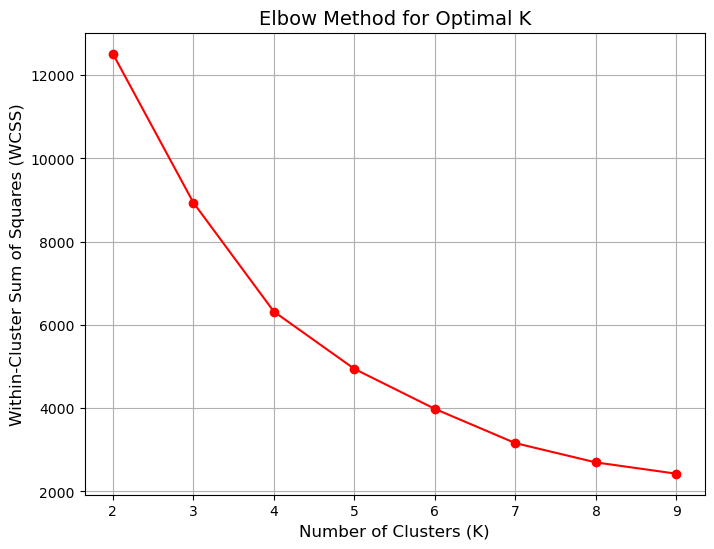

In [58]:
import matplotlib.pyplot as plt

wcss = []
K_range = range(2, 10)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)  
    wcss.append(kmeans.inertia_)  # Inertia = WCSS metric in K-Means



plt.figure(figsize=(8, 6))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='r')


plt.title('Elbow Method for Optimal K', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.grid(True)
plt.show()



The elbow appears to be at K = 4. Up until K=4, the WCSS decreases significantly, but after that, the reduction in WCSS becomes more gradual. The optimal K for customer data is 4.

In [59]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42) #Randomly choosing a number of Clusters.
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

customer_data.groupby('Cluster').mean()

,Quantity,UnitPrice,Frequency,InvoiceDate,TotalSpend,Recency
Cluster,,,,,,
0,1123.563843,4.086280,102.840086,2011-10-30 18:12:05.046040576,3.771010e+03,39.254758
1,60307.000000,4.314829,2418.000000,2011-12-05 09:29:24.000000256,2.519693e+05,3.733333
2,259.547858,19.371957,27.337284,2011-04-06 20:48:08.258887936,1.310010e+03,246.147675
3,21475.500000,135.421382,146.000000,2011-10-26 23:57:00.000000000,2.347142e+06,43.000000


The cluster centroids for the features show the average behavior of customers in each cluster. Cluster 1 shows customers who have purchased in large quantities (21,475) and at high unit prices (135.42), indicating that they may be high-value customers.
Cluster 2, on the other hand, has much lower quantities and unit prices, suggesting these customers may be more occasional or lower-value buyers. Cluster 0 may represent small-scale buyers, and Cliuster 3 may represent large-scale buyers.

# Model Selection

Using the 4-means Clustering as a benchmark to compare to other algorithms like Agglomerative Clustering, and DBSCAN.

## Bootstrapping

In [60]:
# silhouette scores for each algorithm
scores_kmeans = []
scores_agglomerative = []
scores_dbscan = []

# Store the best parameters for each algorithm
best_kmeans_params = {'n_clusters': 0, 'silhouette_score': 0}
best_agglo_params = {'n_clusters': 0, 'silhouette_score': 0}
best_dbscan_params = {'eps': 0, 'min_samples': 0, 'silhouette_score': 0}


In [61]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

In [62]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.utils import resample
from joblib import Parallel, delayed

n_bootstraps = 50

def process_bootstrap(i, scaled_data):
    np.random.seed(i)
    X_bootstrap = resample(scaled_data, replace=True, n_samples=len(scaled_data))
    
    results = {
        'kmeans': {'score': 0, 'params': {}},
        'agglo': {'score': 0, 'params': {}},
        'dbscan': {'score': 0, 'params': {}}
    }
    
    # K-Means
    k = 4  # optimal k from elbow method
    kmeans = KMeans(n_clusters=k, random_state=i)
    labels = kmeans.fit_predict(X_bootstrap)
    score = calinski_harabasz_score(X_bootstrap, labels)
    results['kmeans'] = {'score': score, 'params': {'n_clusters': k}}
    
    # Agglomerative Clustering
    for k in range(2, 10):
        agglo = AgglomerativeClustering(n_clusters=k)
        labels = agglo.fit_predict(X_bootstrap)
        score = calinski_harabasz_score(X_bootstrap, labels)
        if score > results['agglo']['score']:
            results['agglo'] = {'score': score, 'params': {'n_clusters': k}}
    
    # DBSCAN
    eps_range = np.linspace(0.1, 1.5, 10)
    min_samples_range = range(3, 10)
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_bootstrap)
            if len(set(labels)) > 1:
                score = calinski_harabasz_score(X_bootstrap, labels)
                if score > results['dbscan']['score']:
                    results['dbscan'] = {'score': score, 'params': {'eps': eps, 'min_samples': min_samples}}
    
    return results

# Main execution
n_bootstraps = 100  # Adjust as needed
results = Parallel(n_jobs=-1)(delayed(process_bootstrap)(i, scaled_data) for i in range(n_bootstraps))

# Aggregate results
best_params = {
    'kmeans': {'score': 0, 'params': {}},
    'agglo': {'score': 0, 'params': {}},
    'dbscan': {'score': 0, 'params': {}}
}

for r in results:
    for method in best_params:
        if r[method]['score'] > best_params[method]['score']:
            best_params[method] = r[method]

print("Best parameters:")
for method, params in best_params.items():
    print(f"{method}: {params}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Best parameters:
kmeans: {'score': 4921.307322435948, 'params': {'n_clusters': 4}}
agglo: {'score': 7135.945038032339, 'params': {'n_clusters': 9}}
dbscan: {'score': 2240.9266291101453, 'params': {'eps': 1.5, 'min_samples': 6}}


# Best Model

In [63]:
best_algorithm = max(best_params.items(), key=lambda x: x[1]['score'])

# Select and fit the best model
if best_algorithm[0] == 'kmeans':
    final_model = KMeans(n_clusters=best_params['kmeans']['params']['n_clusters'], random_state=42)
elif best_algorithm[0] == 'agglo':
    final_model = AgglomerativeClustering(n_clusters=best_params['agglo']['params']['n_clusters'])
else:  # DBSCAN
    final_model = DBSCAN(eps=best_params['dbscan']['params']['eps'], 
                         min_samples=best_params['dbscan']['params']['min_samples'])

# Fit on full dataset
final_labels = final_model.fit_predict(scaled_data)

# Add the cluster labels to the original dataframe
customer_data['Cluster'] = final_labels

# Print information about the best model
print(f"Best algorithm: {best_algorithm[0]}")
print(f"Best parameters: {best_params[best_algorithm[0]]['params']}")
print(f"Number of clusters: {len(np.unique(final_labels))}")

# Display the first few rows of the updated dataframe
print(customer_data[['Cluster']].head())

# Optional: Calculate the distribution of clusters
cluster_distribution = customer_data['Cluster'].value_counts(normalize=True)
print("\nCluster distribution:")
print(cluster_distribution)



Best algorithm: agglo
Best parameters: {'n_clusters': 9}
Number of clusters: 9
            Cluster
CustomerID         
12346.0           2
12347.0           5
12348.0           5
12349.0           5
12350.0           2

Cluster distribution:
Cluster
5    0.587603
2    0.193962
7    0.119396
8    0.085773
0    0.009835
3    0.001830
4    0.000915
1    0.000457
6    0.000229
Name: proportion, dtype: float64


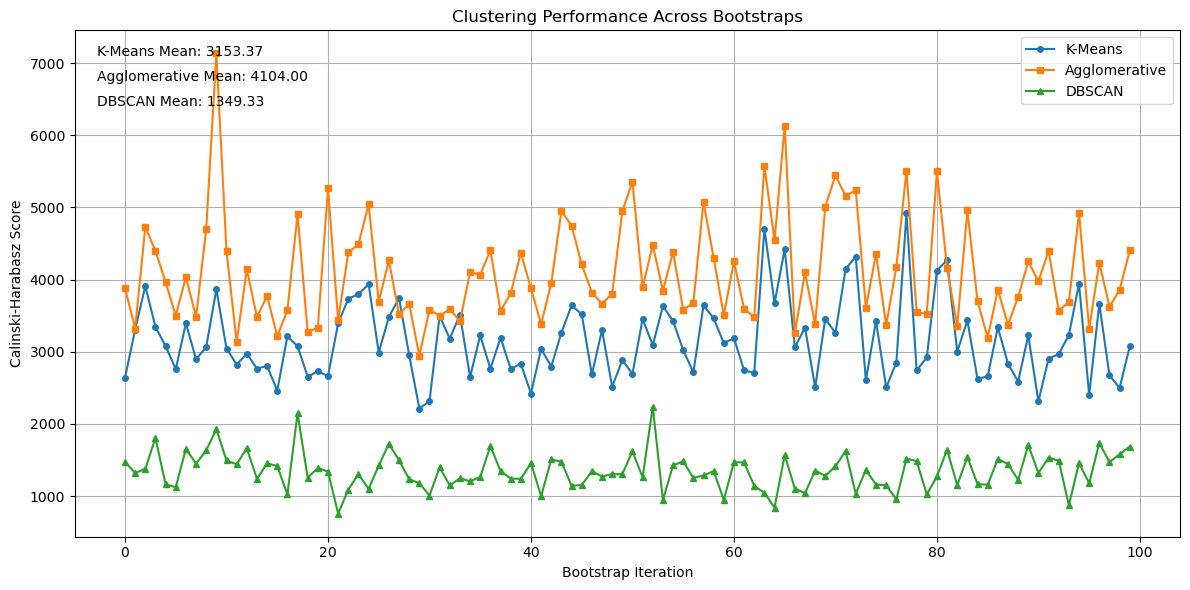


Best Kmeans parameters:
Score: 4921.31
Parameters: {'n_clusters': 4}

Best Agglo parameters:
Score: 7135.95
Parameters: {'n_clusters': 9}

Best Dbscan parameters:
Score: 2240.93
Parameters: {'eps': 1.5, 'min_samples': 6}


In [64]:
import matplotlib.pyplot as plt
import numpy as np

def plot_clustering_performance(results):
    n_bootstraps = len(results)
    
    # Extract scores for each algorithm
    scores_kmeans = [r['kmeans']['score'] for r in results]
    scores_agglomerative = [r['agglo']['score'] for r in results]
    scores_dbscan = [r['dbscan']['score'] for r in results]

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot scores for each algorithm
    plt.plot(range(n_bootstraps), scores_kmeans, label='K-Means', marker='o', linestyle='-', markersize=4)
    plt.plot(range(n_bootstraps), scores_agglomerative, label='Agglomerative', marker='s', linestyle='-', markersize=4)
    plt.plot(range(n_bootstraps), scores_dbscan, label='DBSCAN', marker='^', linestyle='-', markersize=4)

    # Add labels and title
    plt.xlabel('Bootstrap Iteration')
    plt.ylabel('Calinski-Harabasz Score')
    plt.title('Clustering Performance Across Bootstraps')
    plt.legend(loc='best')
    plt.grid(True)

    # Add text annotations for mean scores
    mean_kmeans = np.mean(scores_kmeans)
    mean_agglomerative = np.mean(scores_agglomerative)
    mean_dbscan = np.mean(scores_dbscan)

    plt.annotate(f'K-Means Mean: {mean_kmeans:.2f}', xy=(0.02, 0.95), xycoords='axes fraction')
    plt.annotate(f'Agglomerative Mean: {mean_agglomerative:.2f}', xy=(0.02, 0.90), xycoords='axes fraction')
    plt.annotate(f'DBSCAN Mean: {mean_dbscan:.2f}', xy=(0.02, 0.85), xycoords='axes fraction')

    plt.tight_layout()
    plt.show()

# Assuming 'results' is the list of dictionaries returned from the parallel processing
plot_clustering_performance(results)

# Print out the best parameters for each algorithm
for algorithm in ['kmeans', 'agglo', 'dbscan']:
    best_score = max(r[algorithm]['score'] for r in results)
    best_params = next(r[algorithm]['params'] for r in results if r[algorithm]['score'] == best_score)
    print(f"\nBest {algorithm.capitalize()} parameters:")
    print(f"Score: {best_score:.2f}")
    print(f"Parameters: {best_params}")

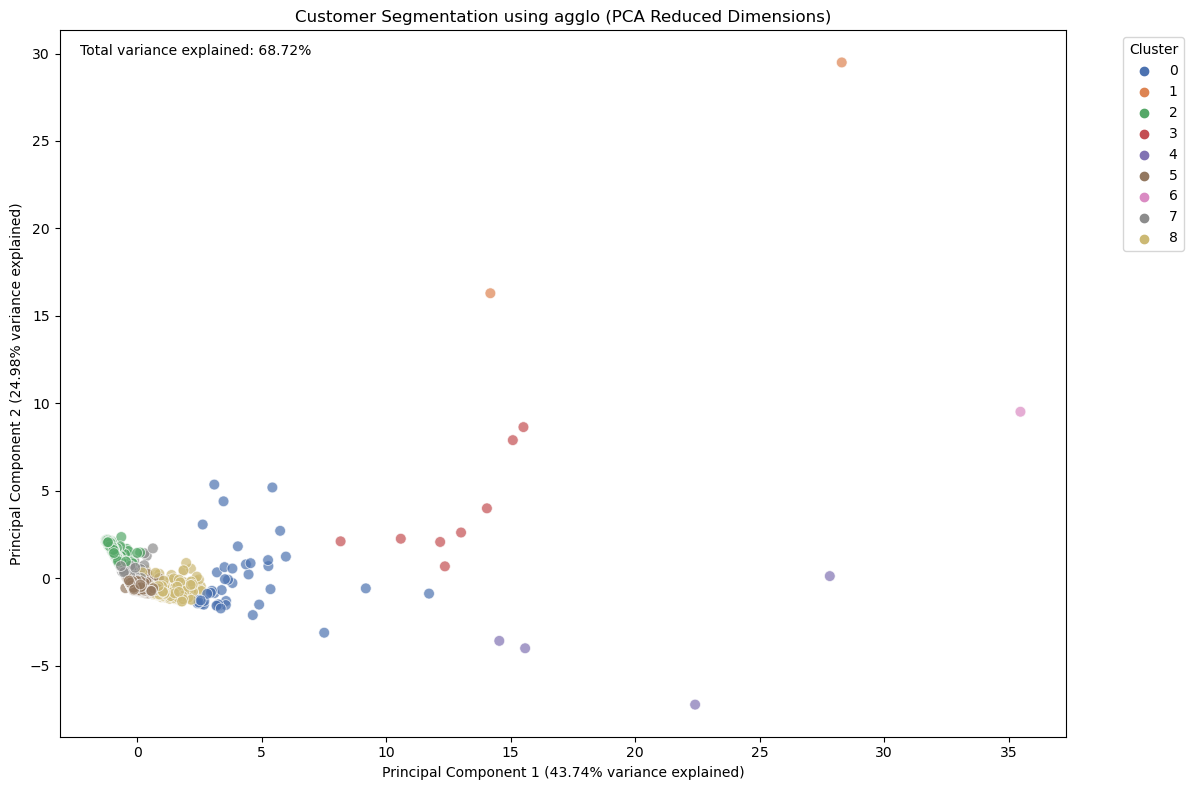


Top features contributing to principal components:

PC1 top contributors:
Feature 0    0.631127
Feature 1    0.558933
Feature 2    0.449000
Feature 3    0.296093
Name: PC1, dtype: float64

PC2 top contributors:
Feature 3    0.778183
Feature 2    0.555763
Feature 1    0.233356
Feature 0    0.176363
Name: PC2, dtype: float64


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_pca_clusters(scaled_data, cluster_labels, best_algorithm):
    # Reduce the dimensionality to 2D using PCA
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled_data)

    # Create a DataFrame for easier plotting
    import pandas as pd
    pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = cluster_labels

    # Plot the clusters after reducing dimensions
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='deep', s=60, alpha=0.7)

    plt.title(f'Customer Segmentation using {best_algorithm} (PCA Reduced Dimensions)')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')

    # Improve legend
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add a brief explanation
    total_var = pca.explained_variance_ratio_.sum()
    plt.annotate(f'Total variance explained: {total_var:.2%}', 
                 xy=(0.02, 0.98), xycoords='axes fraction',
                 fontsize=10, ha='left', va='top')

    plt.tight_layout()
    plt.show()

    # Print top features contributing to each principal component
    print("\nTop features contributing to principal components:")
    feature_importance = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(2)],
        index=scaled_data.columns if hasattr(scaled_data, 'columns') else [f'Feature {i}' for i in range(scaled_data.shape[1])]
    ).abs()

    for i in range(2):
        print(f"\nPC{i+1} top contributors:")
        print(feature_importance[f'PC{i+1}'].nlargest(5))

# Assuming we have the following from previous steps:
# - scaled_data: The scaled dataset used for clustering
# - final_labels: The cluster labels from the best algorithm
# - best_algorithm: The name of the best performing algorithm

plot_pca_clusters(scaled_data, final_labels, best_algorithm[0])

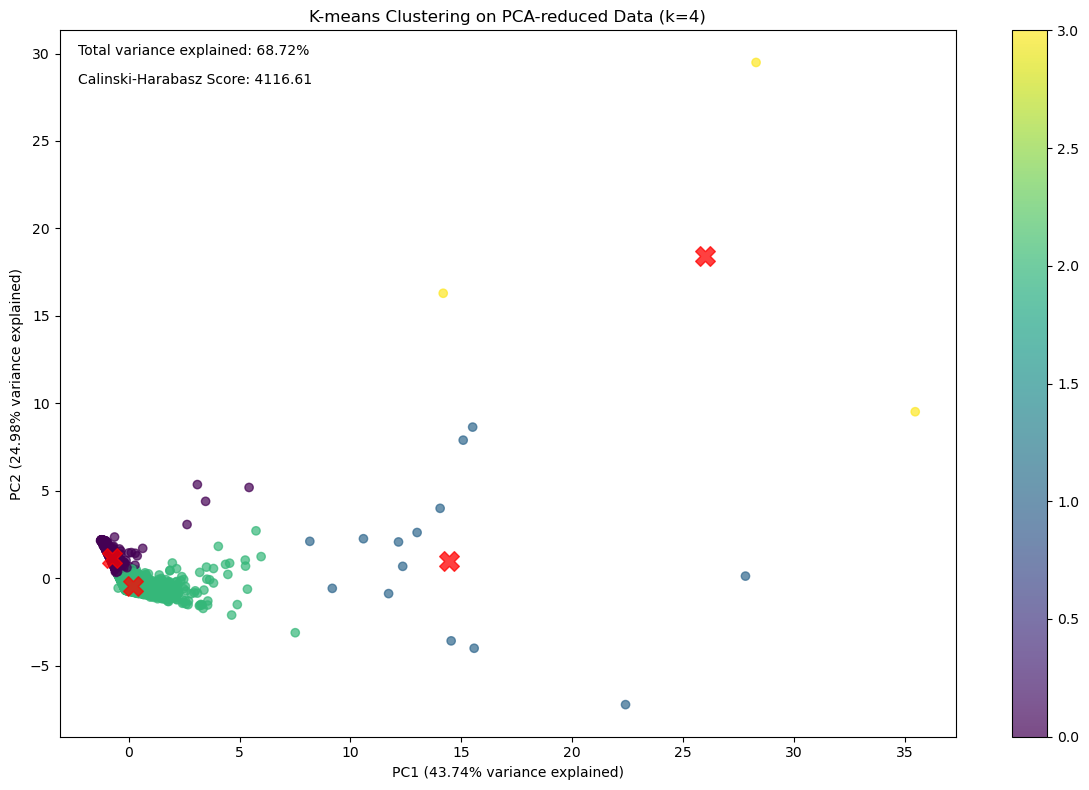


Top features contributing to principal components:

PC1 top contributors:
Feature 0    0.631127
Feature 1    0.558933
Feature 2    0.449000
Feature 3    0.296093
Name: PC1, dtype: float64

PC2 top contributors:
Feature 3    0.778183
Feature 2    0.555763
Feature 1    0.233356
Feature 0    0.176363
Name: PC2, dtype: float64

Calinski-Harabasz Score: 4116.61
Number of samples in each cluster:
0    1154
1      14
2    3201
3       3
Name: count, dtype: int64


In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

def pca_kmeans_analysis(scaled_data, n_components=2, n_clusters=4, random_state=42):
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)
    
    # Perform K-means clustering on PCA-reduced data
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(pca_data)
    
    # Calculate Calinski-Harabasz score
    ch_score = calinski_harabasz_score(pca_data, cluster_labels)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    
    plt.title(f'K-means Clustering on PCA-reduced Data (k={n_clusters})')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')
    
    # Add cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
    
    # Add annotations
    total_var = pca.explained_variance_ratio_.sum()
    plt.annotate(f'Total variance explained: {total_var:.2%}', 
                 xy=(0.02, 0.98), xycoords='axes fraction',
                 fontsize=10, ha='left', va='top')
    plt.annotate(f'Calinski-Harabasz Score: {ch_score:.2f}', 
                 xy=(0.02, 0.94), xycoords='axes fraction',
                 fontsize=10, ha='left', va='top')
    
    plt.tight_layout()
    plt.show()
    
    # Print top features contributing to each principal component
    print("\nTop features contributing to principal components:")
    feature_importance = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=scaled_data.columns if hasattr(scaled_data, 'columns') else [f'Feature {i}' for i in range(scaled_data.shape[1])]
    ).abs()

    for i in range(n_components):
        print(f"\nPC{i+1} top contributors:")
        print(feature_importance[f'PC{i+1}'].nlargest(5))
    
    return pca, kmeans, cluster_labels, ch_score

# Assuming we have scaled_data from previous steps
# and best_kmeans_params from our earlier optimization

# Use the optimal number of clusters found earlier
n_clusters = 4

# Perform PCA and K-means analysis
pca, kmeans, cluster_labels, ch_score = pca_kmeans_analysis(scaled_data, n_components=2, n_clusters=n_clusters)

# Add cluster labels to the original dataframe
customer_data['Cluster'] = cluster_labels

print(f"\nCalinski-Harabasz Score: {ch_score:.2f}")
print(f"Number of samples in each cluster:\n{pd.Series(cluster_labels).value_counts().sort_index()}")